In [86]:
import os
import glob
import IPython.display as ipd

import numpy as np
from scipy.stats import norm, kurtosis, skew

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

import librosa
import librosa.display as ld
from scipy import signal
import soundfile as sf

import pandas as pd
import torch

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
# jupyter kernel interrupt sends SIGINT so need to implement this manually for some reason
import signal, sys
terminate = False

def signal_handling(signum, frame):
    global terminate
    terminate = True
    
'''
compiling all the spectrograms here


for s in curr_songs:
#     print(s['title'])
    signal, sr = s['signal'], s['sr']
    print(signal.shape)
    
    librosa.display.waveplot(signal, sr=sr)
    plt.show()
    
    X = librosa.stft(signal)
    X_db = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    ld.specshow(X_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    
    plt.show()
'''

In [ ]:
'''
central moments:
    - mean, std_dev, skewness, and kurtosis of signal amplitude
zero crossing rate (quantify the "noisiness" of timbral texture):
    - divide entire signal into smaller frames
    - find num of zcr per frame (frame_length=2048)
    - feature: average + sigma of zcr across all frames
tempo:
    - librosa has a function for it (computes tempogram, estimates single value)
chroma features:
    - aggregate across frames --> mean + sigma

spectral centroid (geometric mean of fourier spectrum of audio signal, ie overall brightness or darkness of timbre)
rolloff frequency (similar to general brightness of song)
mel frequency cepstral coefficients(mimics human auditory spectrum in filtering spectrum)
RMS(amplitude in time domain, loudness measure)
spectral contrast:
    - diff btwn max and min magnitudes of frequencies
spectral bandwidth
spectral flatness
chromagram of power spectrogram
silence counting


note: clustering on zero crossing rate can provide a way to discriminate between some audio that may be only speech
vs the music audio we want (voice-only includes a much higher zero crossing rate), i think silence counting can also
apply here

'''

In [4]:
songs = []
curr_count = 0

# signal needs to be in this cell for the SIGINT to flow through (SIX YEAR OLD BUG??)
signal.signal(signal.SIGINT, signal_handling)

for fname in glob.glob("../youtubescraper/spotify_yt_data/*.flac"):
    try:
        if curr_count == 300:
            break
        if terminate:
            terminate=False
            break
        song_id = fname.split('/')[-1].split('.')[0]
        data, sr = sf.read(fname)

        # mono
        channel = 1

        # stereo
        if data.ndim == 2:
            data = (data[:,0] + data[:,1]) / 2
            channel = 2

        s = {
            'id': song_id,
            'signal': data,
            'sr': sr,
            'channel': channel
        }
        songs.append(s)
        curr_count += 1
    except:
        print(fname)
        continue
print(curr_count)

300


In [6]:
metadata = pd.read_csv("./metadata.csv")
print(metadata.head())

            id              artist  \
0  l_7TWVX4EOk                 NaN   
1  fRPNEtRakns                 NaN   
2  BbgWSN95V8k  Rebirth Brass Band   
3  hJsOd3PWcAM      Gregory Isaacs   
4  XQF69A3oGjM              Koffee   

                                               title  duration  
0  Anarchy in the U.K. Lullaby Versions of Sex Pi...       215  
1  WITHOUT YOU (Workout Remix) by Power Music Wor...       221  
2                  Feel Like Funking It Up (Part II)       410  
3                     Gregory Isaacs - Long Sentence       221  
4              Koffee - W (Official Video) ft. Gunna       281  


In [7]:
# keeping one channel songs, everything is mono now, appending some metadata here
for s in songs:
    s_metadata = metadata.loc[metadata['id'] == s['id']]
    s['artist'] = s_metadata['artist'].iloc[0]
    s['title'] = s_metadata['title'].iloc[0]
    s['duration'] = s_metadata['duration'].iloc[0]
    

In [8]:
df = pd.DataFrame(songs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        300 non-null    object
 1   signal    300 non-null    object
 2   sr        300 non-null    int64 
 3   channel   300 non-null    int64 
 4   artist    231 non-null    object
 5   title     300 non-null    object
 6   duration  300 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 16.5+ KB


In [9]:
# max duration 8 minutes
df = df.loc[df['duration'] <= 480]

# min duration 3 minutes
df = df.loc[df['duration'] >= 180]

# remove rows where no signal was able to be extracted (at least one case of it due to being an interview)
df = df[df['signal'].map(lambda x: len(x) > 0)]
df = df.reset_index()

# # resampling all audio to min (so far it's 44.1k) to help with standardization
# sr_min = df['sr'].min()
# sr_mask = (df['sr'] != sr_min)
# df.loc[sr_mask, 'signal'] = df['signal'].loc[sr_mask].apply(lambda x: signal.resample(x, sr_min))


In [10]:
'''

Here we get all the frequency level features. First they're computed using librosa,
then we reduce them to their mean, variance, kurtosis, skew.Of course these result in 
very general characteristics of each songs, but they provide a high level, quicker 
feature mapping for clustering; the CNN architecture will provide a more granular 
mapping of particular feature quirks and details.

we need to add a constant bias, primarily for zero crossing rate, to handle the silence
in the beginning of any song, which can have variable length before the music actually begins
for now we set this to 0.001, but we may have to revisit this to see if it affects anything else
which it shouldn't, as the distribution of freqs is the same.

'''
ZERO_CROSSING_RATE_BIAS = 0.001
def run_freq_stats(df):
    '''
    TODO: automate feature run in this function
    '''
    features = ['zcr', 'spectral_centroid', 'rolloff_frequency', 'mfcc', 'spectral_contrast', 'spectral_bandwidth', 'spectral_flatness']
    signal = df['signal']
    sr = df['sr']
    pass
test_df = df.copy()

# adding this bias is SUPER computationally costly in jupyter for some reason
# test_df['signal'] += ZERO_CROSSING_RATE_BIAS

In [15]:
df['title'].iloc[:10]

0                      I Wayne - I need her in my arms
1    Check Yes or No - Lullaby Versions of George S...
2                           Get In There (feat. Level)
3                            God Will Take Care of You
4                Fazlija - Gdje si mori - (Audio 2000)
5                           Jehst - High Plains Anthem
6    Anarchy in the U.K. Lullaby Versions of Sex Pi...
7    WITHOUT YOU (Workout Remix) by Power Music Wor...
8                    Feel Like Funking It Up (Part II)
9                       Gregory Isaacs - Long Sentence
Name: title, dtype: object

In [16]:
# getting zero-crossing rate
test_df['zcr'] = test_df['signal'].apply(lambda x: librosa.feature.zero_crossing_rate(x + ZERO_CROSSING_RATE_BIAS))

test_df['zcr_mean'] = test_df['zcr'].apply(lambda x: np.mean(x))
test_df['zcr_var'] = test_df['zcr'].apply(lambda x: np.var(x, ddof=1))
test_df['zcr_kurtosis'] = test_df['zcr'].apply(lambda x: kurtosis(np.ndarray.flatten(x), fisher=True))
test_df['zcr_skew'] = test_df['zcr'].apply(lambda x: skew(np.ndarray.flatten(x)))

In [19]:
# getting spectral centroid
test_df['spectral_centroid'] = test_df.apply(lambda x: librosa.feature.spectral_centroid(y=x['signal'], sr=x['sr']), axis=1)

test_df['spectral_centroid_mean'] = test_df['spectral_centroid'].apply(lambda x: np.mean(x))
test_df['spectral_centroid_var'] = test_df['spectral_centroid'].apply(lambda x: np.var(x, ddof=1))
test_df['spectral_centroid_kurtosis'] = test_df['spectral_centroid'].apply(lambda x: kurtosis(np.ndarray.flatten(x), fisher=True))
test_df['spectral_centroid_skew'] = test_df['spectral_centroid'].apply(lambda x: skew(np.ndarray.flatten(x)))

In [20]:
# getting rolloff frequency, default percent is 0.85
test_df['rolloff_frequency'] = test_df.apply(lambda x: librosa.feature.spectral_rolloff(y=x['signal'], sr=x['sr']), axis=1)

test_df['rolloff_frequency_mean'] = test_df['rolloff_frequency'].apply(lambda x: np.mean(x))
test_df['rolloff_frequency_var'] = test_df['rolloff_frequency'].apply(lambda x: np.var(x, ddof=1))
test_df['rolloff_frequency_kurtosis'] = test_df['rolloff_frequency'].apply(lambda x: kurtosis(np.ndarray.flatten(x), fisher=True))
test_df['rolloff_frequency_skew'] = test_df['rolloff_frequency'].apply(lambda x: skew(np.ndarray.flatten(x)))

In [21]:
# getting mel coefficients
test_df['mfcc'] = test_df.apply(lambda x: librosa.feature.mfcc(y=x['signal'], sr=x['sr']), axis=1)

test_df['mfcc_mean'] = test_df['mfcc'].apply(lambda x: np.mean(x))
test_df['mfcc_var'] = test_df['mfcc'].apply(lambda x: np.var(x, ddof=1))
test_df['mfcc_kurtosis'] = test_df['mfcc'].apply(lambda x: kurtosis(np.ndarray.flatten(x), fisher=True))
test_df['mfcc_skew'] = test_df['mfcc'].apply(lambda x: skew(np.ndarray.flatten(x)))

In [22]:
# spectral contrast
test_df['spectral_contrast'] = test_df.apply(lambda x: librosa.feature.spectral_contrast(y=x['signal'], sr=x['sr']), axis=1)

test_df['spectral_contrast_mean'] = test_df['spectral_contrast'].apply(lambda x: np.mean(x))
test_df['spectral_contrast_var'] = test_df['spectral_contrast'].apply(lambda x: np.var(x, ddof=1))
test_df['spectral_contrast_kurtosis'] = test_df['spectral_contrast'].apply(lambda x: kurtosis(np.ndarray.flatten(x), fisher=True))
test_df['spectral_contrast_skew'] = test_df['spectral_contrast'].apply(lambda x: skew(np.ndarray.flatten(x)))

In [23]:
# spectral bandwidth
test_df['spectral_bandwidth'] = test_df.apply(lambda x: librosa.feature.spectral_bandwidth(y=x['signal'], sr=x['sr']), axis=1)

test_df['spectral_bandwidth_mean'] = test_df['spectral_bandwidth'].apply(lambda x: np.mean(x))
test_df['spectral_bandwidth_var'] = test_df['spectral_bandwidth'].apply(lambda x: np.var(x, ddof=1))
test_df['spectral_bandwidth_kurtosis'] = test_df['spectral_bandwidth'].apply(lambda x: kurtosis(np.ndarray.flatten(x), fisher=True))
test_df['spectral_bandwidth_skew'] = test_df['spectral_bandwidth'].apply(lambda x: skew(np.ndarray.flatten(x)))

In [30]:
# get spectral flatness
test_df['spectral_flatness'] = test_df['signal'].apply(librosa.feature.spectral_flatness)

test_df['spectral_flatness_mean'] = test_df['spectral_flatness'].apply(lambda x: np.mean(x))
test_df['spectral_flatness_var'] = test_df['spectral_flatness'].apply(lambda x: np.var(x, ddof=1))
test_df['spectral_flatness_kurtosis'] = test_df['spectral_flatness'].apply(lambda x: kurtosis(np.ndarray.flatten(x), fisher=True))
test_df['spectral_flatness_skew'] = test_df['spectral_flatness'].apply(lambda x: skew(np.ndarray.flatten(x)))

In [36]:
test_df.columns

Index(['index', 'id', 'signal', 'sr', 'channel', 'artist', 'title', 'duration',
       'zcr_mean', 'zcr_var', 'zcr_kurtosis', 'zcr_skew',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_centroid_kurtosis', 'spectral_centroid_skew',
       'rolloff_frequency_mean', 'rolloff_frequency_var',
       'rolloff_frequency_kurtosis', 'rolloff_frequency_skew', 'mfcc_mean',
       'mfcc_var', 'mfcc_kurtosis', 'mfcc_skew', 'spectral_contrast_mean',
       'spectral_contrast_var', 'spectral_contrast_kurtosis',
       'spectral_contrast_skew', 'spectral_bandwidth_mean',
       'spectral_bandwidth_var', 'spectral_bandwidth_kurtosis',
       'spectral_bandwidth_skew', 'spectral_flatness_mean',
       'spectral_flatness_var', 'spectral_flatness_kurtosis',
       'spectral_flatness_skew'],
      dtype='object')

In [32]:
test_df.drop(columns=[
    'zcr', 
    'spectral_centroid', 
    'rolloff_frequency', 
    'mfcc', 
    'spectral_contrast', 
    'spectral_bandwidth', 
    'spectral_flatness'], 
             inplace=True, axis=1)

In [76]:
'''
standardizing everything and then running PCA, setting explained variance==.95 (we can range .95-.99)

note: need to compile literally all our data together before standardizing to perform proper PCA
'''
pca = PCA(n_components=3)
non_features = ['index', 'id', 'signal', 'sr', 'channel', 'artist', 'title', 'duration']

# df with features only
data = test_df[test_df.columns.difference(non_features)]

# standardize features
scaled_df = (data - data.mean()) / data.std()

In [78]:
pc_components = pca.fit_transform(scaled_df)

principal_df = pd.DataFrame(data=pc_components, columns=['pca1', 'pca2', 'pca3'])
compiled_df = pd.concat([principal_df, test_df[['id']]], axis=1)

In [79]:
compiled_df.head()

,pca1,pca2,pca3,id
0,-1.344625,1.596683,-0.079616,scbeMwGaYJs
1,6.376245,2.221722,0.366328,dJ6I1WY-VAw
2,-4.126608,0.698149,0.799527,EE94VcQ8xw0
3,-1.203996,-4.458642,1.150320,4EhZrkzGOUA
4,-0.048272,-0.810817,-1.493806,GcYRJhQ7bws


In [83]:
model = KMeans(n_clusters=3)
model.fit(compiled_df[compiled_df.columns.difference(['id'])])
centroids = model.cluster_centers_

array([[ 6.75531681,  1.00523416, -1.1812469 ],
       [-2.33577124,  0.04351508, -0.43312045],
       [ 1.04683266, -0.25467837,  0.70016784]])

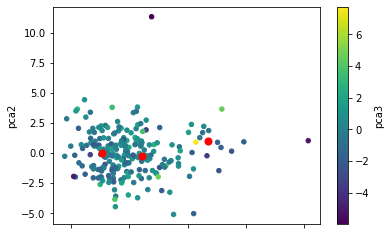

In [84]:
ax1 = compiled_df.plot.scatter(x='pca1', y='pca2', c='pca3', colormap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
for i, label 

In [102]:
def find_dist(centroid, y):
    dist = np.linalg.norm(centroid - y)
    return dist

In [106]:
compiled_df['centroid_0_dist'] = compiled_df.apply(lambda x: find_dist(centroid=centroids[0], y=np.array([x['pca1'], x['pca2'], x['pca3']])), axis=1)
compiled_df['centroid_1_dist'] = compiled_df.apply(lambda x: find_dist(centroid=centroids[1], y=np.array([x['pca1'], x['pca2'], x['pca3']])), axis=1)
compiled_df['centroid_2_dist'] = compiled_df.apply(lambda x: find_dist(centroid=centroids[2], y=np.array([x['pca1'], x['pca2'], x['pca3']])), axis=1)

In [110]:
print(compiled_df['centroid_0_dist'].min())
print(compiled_df['centroid_1_dist'].min())
print(compiled_df['centroid_2_dist'].min())
print()
print(compiled_df['centroid_0_dist'].max())
print(compiled_df['centroid_1_dist'].max())
print(compiled_df['centroid_2_dist'].max())

0.19411716371112642
0.3263035656202036
0.36707755892360694

12.520386993623996
18.29719489116026
15.468997320828848


In [113]:
first = compiled_df.loc[compiled_df['centroid_0_dist'] == compiled_df['centroid_0_dist'].min()]
second = compiled_df.loc[compiled_df['centroid_1_dist'] == compiled_df['centroid_1_dist'].min()]
third = compiled_df.loc[compiled_df['centroid_2_dist'] == compiled_df['centroid_2_dist'].min()]

In [114]:
print(first, second, third)

         pca1      pca2     pca3           id  centroid_0_dist  \
137  6.769601  0.880467 -1.32927  TMyQR9x5Qc4         0.194117   

     centroid_1_dist  centroid_2_dist  
137         9.187566         6.177155            pca1      pca2      pca3           id  centroid_0_dist  \
219 -2.317459 -0.043265 -0.119102  ULmQ7E0mIKw         9.194714   

     centroid_1_dist  centroid_2_dist  
219         0.326304         3.469057            pca1      pca2      pca3           id  centroid_0_dist  \
178  0.850934 -0.025555  0.909624  DHcHGv0g200         6.347914   

     centroid_1_dist  centroid_2_dist  
178         3.458731         0.367078  


In [119]:
df.loc[df['id'] == 'ULmQ7E0mIKw']

,index,id,signal,sr,channel,artist,title,duration
219,287,ULmQ7E0mIKw,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,2,Adema,Refusing Consciousness,205


In [120]:
df.loc[df['id'] == 'DHcHGv0g200']

,index,id,signal,sr,channel,artist,title,duration
178,232,DHcHGv0g200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,2,NaN,Heather Nova - Everything Changes,220


In [121]:
df.loc[df['id'] == 'TMyQR9x5Qc4']

,index,id,signal,sr,channel,artist,title,duration
137,181,TMyQR9x5Qc4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,2,NaN,Cheap Thrills Lullaby Versions of Sia by Twink...,287
